## Train an LSTM Model for Next Day Prediction Using Extracted Features

In [187]:
! pip install -U -q "neptune[tensorflow-keras]" tensorflow ta

In [280]:
import neptune
import logging
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import matplotlib.patches as patches
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
from ta.momentum import RSIIndicator
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from neptune.integrations.tensorflow_keras import NeptuneCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.optimize import minimize

In [189]:
# Disable specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="accelerate")
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
warnings.filterwarnings("ignore", module="sklearn.metrics._classification")
neptune_logger = logging.getLogger('neptune')
neptune_logger.setLevel(logging.ERROR)

In [190]:
plt.style.use('default')

In [191]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Neptune Init

In [278]:
# Define the Neptune initialization function (assuming it's in your code)
def init_neptune_run(name, description, params, tags, notebook_addr='/content/drive/MyDrive//LSTM_Impact_Compare.ipynb'):
    """
    Initializes and returns an instance of a Neptune run and sends the parameters
    """
    run = neptune.init_run(
        project='Financial-NLP/LSTM-Predictor',
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlYTFiMTEwZS0zY2Q5LTQ3MGItODZjZS0zMTcwM2RjMzZmNjAifQ==",
        name=name,
        tags=tags,
        description=description
    )

    run["notebook"].upload(notebook_addr)
    run["parameters"] = params
    return run

# Parameters for the Neptune run
params = {
    "model_type": "LSTM",
    "layers": [
        {"LSTM": 128, "return_sequences": True},
        {"Dropout": 0.2},
        {"LSTM": 64, "return_sequences": False},
        {"Dropout": 0.2},
        {"Dense": 32, "activation": "relu", "kernel_regularizer": "l2(0.005)"},
        {"Dense": 32, "activation": "relu", "kernel_regularizer": "l2(0.005)"},
        {"Dense": 3, "activation": "softmax"},
    ],
    "optimizer": "Adam",
    "learning_rate": 0.0005,
    "epochs": 100,
    "batch_size": 128,
}

# Initialize Neptune run
run = init_neptune_run(
    name="Compare LSTM model predictions with impact mean and impact majority.",
    description="Train LSTM model using KFold method and compare its measurements with impact mean and impact majority labels measurements.",
    params=params,
    tags=["LSTM", "training", "classification", "Impact-Mean", "Impact-Majority"]
)

### Load the price data

In [195]:
mean_file_path = '/content/drive/MyDrive/impact_mean.csv'

impact_mean = pd.read_csv(mean_file_path)
impact_mean = impact_mean.rename(columns={'date': 'timestamp'})
impact_mean = impact_mean.set_index('timestamp')
impact_mean

,signal
timestamp,
2015-02-08,0
2015-02-09,0
2015-02-10,0
2015-02-11,0
2015-02-12,0
...,...
2021-02-11,0
2021-02-12,0
2021-02-13,0


In [196]:
# Map the signal values from [-1, 0, 1] to [0, 1, 2]
impact_mean['mean_label'] = impact_mean['signal'].map({-1: 0, 0: 1, 1: 2})
impact_mean

,signal,mean_label
timestamp,,
2015-02-08,0,1
2015-02-09,0,1
2015-02-10,0,1
2015-02-11,0,1
2015-02-12,0,1
...,...,...
2021-02-11,0,1
2021-02-12,0,1
2021-02-13,0,1


In [197]:
impact_mean.mean_label.value_counts()

,count
mean_label,
1,929
2,698
0,477


In [198]:
ratio_feat = pd.read_csv('/content/drive/MyDrive/ratio_2015_2021.csv')

# Reverse the order of the rows in the ratio_feat DataFrame
ratio_feat = ratio_feat.sort_values(by='timestamp').reset_index(drop=True)
ratio_feat.set_index('timestamp', inplace=True)
ratio_feat = ratio_feat.sort_index()
ratio_feat

,ratio,close
timestamp,,
2015-01-01,1.782609,314.136000
2015-01-02,0.975000,315.207000
2015-01-03,0.250000,284.234000
2015-01-04,0.568627,264.201000
2015-01-05,0.290909,274.570000
...,...,...
2021-02-11,1.319149,47680.424438
2021-02-12,1.351064,47622.568921
2021-02-13,1.390805,47056.769565


In [199]:
# Define the ticker for Bitcoin (BTC-USD is the ticker for Bitcoin in US Dollars on Yahoo Finance)
ticker = "BTC-USD"

# Define the start and end dates
start_date = "2015-01-01"
end_date = "2021-02-16"

# Fetch the historical data from Yahoo Finance
btc_data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the required columns and reset the index to have a column 'timestamp'
btc_data = btc_data[["Open", "High", "Low", "Close", "Volume"]]
btc_data.reset_index(inplace=True)
btc_data.rename(columns={"Date": "timestamp", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"}, inplace=True)
btc_data.set_index('timestamp', inplace=True)

# Display the first few rows of the data
btc_data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
timestamp,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800


In [200]:
# Create a complete date range from 2015-01-01 to 2021-02-15
full_date_range = pd.date_range(start="2015-01-01", end="2021-02-15")

# Find missing dates in ratio_feat compared to the full_date_range
missing_dates_in_ratio_feat = full_date_range.difference(ratio_feat.index)

# Convert the missing dates to a DataFrame (if needed)
missing_dates_df = pd.DataFrame(missing_dates_in_ratio_feat, columns=['timestamp'])

# Print missing dates
print("Missing dates in ratio_feat:")
missing_dates_df

Missing dates in ratio_feat:


,timestamp
0,2015-12-31
1,2016-08-07
2,2016-12-31
3,2017-03-27
4,2017-12-31
...,...
92,2019-03-27
93,2019-03-28
94,2019-03-29
95,2019-03-30


In [201]:
# Convert the 'timestamp' column of missing_dates_df to a list for easy removal
missing_dates = missing_dates_df['timestamp'].tolist()

# Step 1: Remove rows from btc_data with missing timestamps
btc_data_cleaned = btc_data.drop(index=missing_dates, errors='ignore')
len(btc_data_cleaned)

2141

In [202]:
# Convert indices to datetime if they are not already
btc_data_cleaned.index = pd.to_datetime(btc_data_cleaned.index)
ratio_feat.index = pd.to_datetime(ratio_feat.index)

# Ensure both indices are sorted
btc_data_cleaned.sort_index(inplace=True)
ratio_feat.sort_index(inplace=True)

# Check if indices are equal
if not btc_data_cleaned.index.equals(ratio_feat.index):
    print("Indices do not match. Please check the indices of both DataFrames.")
else:
    # Assign the 'ratio' column from ratio_feat to btc_data_cleaned
    btc_data_cleaned['sentiment_ratio'] = ratio_feat['ratio']

    # Check the updated btc_data_cleaned
    btc_data_cleaned.head()

In [203]:
if btc_data_cleaned['sentiment_ratio'].equals(ratio_feat['ratio']):
  print('all equal!')
else:
  print('not equal')

all equal!


In [204]:
# Find missing dates in impact_ratio compared to the btc_data_cleaned
missing_dates_in_impact = btc_data_cleaned.index.difference(impact_mean.index)

# Convert the missing dates to a DataFrame (if needed)
missing_dates_df = pd.DataFrame(missing_dates_in_impact, columns=['timestamp'])

# Print missing dates
print("Missing dates in impact_ratio:")
missing_dates_df

Missing dates in impact_ratio:


,timestamp
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
5,2015-01-06
6,2015-01-07
7,2015-01-08
8,2015-01-09
9,2015-01-10


In [205]:
# Convert the 'timestamp' column of missing_dates_df to a list for easy removal
missing_dates = missing_dates_df['timestamp'].tolist()

# Remove rows from btc_data with missing timestamps
btc_data_cleaned = btc_data_cleaned.drop(index=missing_dates, errors='ignore')
len(btc_data_cleaned)

2103

In [206]:
len(btc_data_cleaned.index), len(impact_mean.index)

(2103, 2104)

In [207]:
# Convert indices to datetime if they are not already
btc_data_cleaned.index = pd.to_datetime(btc_data_cleaned.index)
impact_mean.index = pd.to_datetime(impact_mean.index)

# Find missing dates in impact_mean compared to the btc_data_cleaned
missing_dates_in_impact = impact_mean.index.difference(btc_data_cleaned.index)

# Convert the missing dates to a DataFrame (if needed)
missing_dates_df = pd.DataFrame(missing_dates_in_impact, columns=['timestamp'])

# Print missing dates
print("Missing dates in btc:")
missing_dates_df

Missing dates in btc:


,timestamp
0,2017-03-27


In [208]:
# Convert the 'timestamp' column of missing_dates_df to a list for easy removal
missing_dates = missing_dates_df['timestamp'].tolist()

# Remove rows from btc_data with missing timestamps
impact_mean = impact_mean.drop(index=missing_dates, errors='ignore')
len(impact_mean)

2103

In [209]:
# Convert indices to datetime if they are not already
btc_data_cleaned.index = pd.to_datetime(btc_data_cleaned.index)
impact_mean.index = pd.to_datetime(impact_mean.index)

# Ensure both indices are sorted
btc_data_cleaned.sort_index(inplace=True)
impact_mean.sort_index(inplace=True)

# Check if indices are equal
if not btc_data_cleaned.index.equals(impact_mean.index):
    print("Indices do not match. Please check the indices of both DataFrames.")
else:
    # Assign the 'ratio' column from ratio_feat to btc_data_cleaned
    btc_data_cleaned['impact_ratio'] = impact_mean['mean_label']

    # Check the updated btc_data_cleaned
    btc_data_cleaned.head()

In [210]:
if btc_data_cleaned['impact_ratio'].equals(impact_mean['mean_label']):
  print('all equal!')
else:
  print('not equal')

all equal!


In [211]:
btc_data_cleaned

,open,high,low,close,volume,sentiment_ratio,impact_ratio
timestamp,,,,,,,
2015-02-08,227.692993,229.438004,221.076996,223.412003,17145200,0.348485,1
2015-02-09,223.389008,223.977005,217.018997,220.110001,27791300,0.425926,1
2015-02-10,220.281998,221.807007,215.332001,219.839005,21115100,0.719298,1
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1
...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,1
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,1


In [212]:
price_df = btc_data_cleaned
price_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio
timestamp,,,,,,,
2015-02-08,227.692993,229.438004,221.076996,223.412003,17145200,0.348485,1
2015-02-09,223.389008,223.977005,217.018997,220.110001,27791300,0.425926,1
2015-02-10,220.281998,221.807007,215.332001,219.839005,21115100,0.719298,1
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1
...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,1
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,1


### Triple Barrier Labeling

In [213]:
# Define labels as named constants for readability
LABEL_UP = 2
LABEL_DOWN = 0
LABEL_NEUTRAL = 1

In [214]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
        """
        Calculate the daily volatility of closing prices.

        Parameters:
        - close: A pandas Series of closing prices.
        - span0: The span for the EWM standard deviation.

        Returns:
        - A pandas Series of daily volatility estimates.
        """
        # Find the start of the previous day for each day
        prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        prev_day_start = prev_day_start[prev_day_start > 0]

        # Create a series with the start of the previous day for each day
        prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

        # Calculate daily returns
        daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

        # Calculate EWM standard deviation of daily returns
        daily_vol = daily_returns.ewm(span=span0).std()

        return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=10, optimization_interval='6M'):
    if optimization_interval is None:
        # Use the whole dataset for optimization
        best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(price_df, param_grid, initial_capital, num_starts)
        return pd.DataFrame([{
            'start': price_df.index[0],
            'end': price_df.index[-1],
            'params': best_params,
            'sharpe_ratio': best_sharpe_ratio,
            'net_profit': best_net_profit
        }])
    else:
        # Optimize parameters at specified intervals
        intervals = pd.date_range(start=price_df.index[0], end=price_df.index[-1], freq=optimization_interval)
        optimized_params = []

        for start, end in zip(intervals[:-1], intervals[1:]):
            interval_df = price_df.loc[start:end]
            best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(interval_df, param_grid, initial_capital, num_starts)
            optimized_params.append({
                'start': start,
                'end': end,
                'params': best_params,
                'sharpe_ratio': best_sharpe_ratio,
                'net_profit': best_net_profit
            })

        return pd.DataFrame(optimized_params)

def tune_hyperparameters_scipy(price_df, param_grid, initial_capital=100000, num_starts=10):
    best_sharpe_ratio, best_net_profit, best_params = -np.inf, -np.inf, None

    param_space = [
        param_grid['volatility_period'],
        param_grid['upper_barrier_factor'],
        param_grid['lower_barrier_factor'],
        param_grid['vertical_barrier'],
        param_grid['barrier_type'],
        param_grid['touch_type']
    ]

    bounds = [(0, len(space) - 1) for space in param_space]

    def bounds_to_params(x):
        return {key: space[int(idx)] for key, space, idx in zip(param_grid.keys(), param_space, x)}

    def objective_wrapper(x):
        params = bounds_to_params(x)
        return sharpe_ratio_objective(params, price_df, initial_capital)

    for _ in tqdm(range(num_starts), desc="Optimizing"):
        initial_guess = [np.random.randint(len(space)) for space in param_space]
        result = minimize(objective_wrapper, initial_guess, method='SLSQP', bounds=bounds)

        if result.success and -result.fun > best_sharpe_ratio:
            best_sharpe_ratio = -result.fun
            best_params = bounds_to_params(result.x)
            labeler = TripleBarrierLabeler(**best_params)
            labeler.fit(price_df)
            labeled_df = labeler.transform()
            portfolio_values = buy_and_hold(price_df['close'], labeled_df['label'], initial_capital)
            best_net_profit = portfolio_values.iloc[-1] - initial_capital

    return best_params, best_sharpe_ratio, best_net_profit

def sharpe_ratio_objective(params, price_df, initial_capital):
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(price_df)
    labeled_df = labeler.transform()
    labeled_df.set_index(price_df.index, inplace=True)
    portfolio_values = buy_and_hold(price_df['close'], labeled_df['label'], initial_capital)
    return -calculate_sharpe_ratio(portfolio_values)  # Minimize negative Sharpe Ratio to maximize Sharpe Ratio

def buy_and_hold(price_series, labels, initial_capital=100000, commission_fee=0.001):
    positions, capital = 0, initial_capital
    portfolio_values = []

    for date, label in labels.items():
        price = price_series.loc[date]
        if label == 1:  # Buy
            shares_to_buy = capital // price
            cost = shares_to_buy * price * (1 + commission_fee)
            positions += shares_to_buy
            capital -= cost
        elif label == -1:  # Sell
            revenue = positions * price * (1 - commission_fee)
            capital += revenue
            positions = 0

        portfolio_values.append(capital + positions * price)

    return pd.Series(portfolio_values, index=labels.index)

def calculate_sharpe_ratio(portfolio_values):
    returns = portfolio_values.pct_change().dropna()
    return np.mean(returns) / np.std(returns) * np.sqrt(365)  # Annualized Sharpe Ratio for crypto market

def calculate_net_profit(portfolio_values, initial_capital=100000):
    return portfolio_values.iloc[-1] - initial_capital

In [215]:
# # Define the parameter grid
# param_grid = {
#     'volatility_period': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'upper_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
#     'lower_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
#     'vertical_barrier': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'barrier_type': ['volatility', 'returns'],
#     'touch_type': ['HL', 'C']
# }

# # Optimize parameters every six months
# optimized_params_df = optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=100, optimization_interval='6M')

In [216]:
# optimized_params_df

In [217]:
# optimized_params_df.to_csv('/content/drive/MyDrive/TBL_Optimized_Params.csv')

In [218]:
optimized_params_df = pd.read_csv('/content/drive/MyDrive/TBL_Optimized_Params.csv', index_col=0)
optimized_params_df

,start,end,params,sharpe_ratio,net_profit
0,2015-02-28,2015-08-31,"{'volatility_period': 14, 'upper_barrier_facto...",-0.100025,-9572.192605
1,2015-08-31,2016-02-29,"{'volatility_period': 14, 'upper_barrier_facto...",2.415276,90016.345882
2,2016-02-29,2016-08-31,"{'volatility_period': 6, 'upper_barrier_factor...",1.325760,31312.903694
3,2016-08-31,2017-02-28,"{'volatility_period': 8, 'upper_barrier_factor...",3.173079,104478.594897
4,2017-02-28,2017-08-31,"{'volatility_period': 7, 'upper_barrier_factor...",3.687180,295868.176468
5,2017-08-31,2018-02-28,"{'volatility_period': 15, 'upper_barrier_facto...",1.929905,119485.944139
6,2018-02-28,2018-08-31,"{'volatility_period': 15, 'upper_barrier_facto...",-0.728954,-29388.657469
7,2018-08-31,2019-02-28,"{'volatility_period': 7, 'upper_barrier_factor...",-2.342167,-44501.310301
8,2019-02-28,2019-08-31,"{'volatility_period': 5, 'upper_barrier_factor...",2.776382,131239.746574
9,2019-08-31,2020-02-29,"{'volatility_period': 5, 'upper_barrier_factor...",-0.156991,-10407.859375


In [219]:
# Apply the optimized parameters to label the data
labeled_df = pd.DataFrame()
for _, row in optimized_params_df.iterrows():
    start, end, params = row['start'], row['end'], eval(row['params'])
    interval_df = price_df.loc[start:end]
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(interval_df)
    labeled_interval_df = labeler.transform()
    labeled_df = pd.concat([labeled_df, labeled_interval_df])

# Check the label distribution
labeled_df.label.value_counts()

,count
label,
2,799
1,752
0,373


In [220]:
labeled_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,
2015-02-28,253.520004,254.692001,249.479004,254.263000,13949300,0.812500,1,NaN,NaN,1,True,NaN,NaN
2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,1.466667,2,NaN,NaN,1,False,NaN,NaN
2015-03-02,260.356995,276.300995,258.312988,275.670013,40465700,0.509804,2,0.084192,NaN,1,False,NaN,NaN
2015-03-03,275.045990,285.795990,268.161011,281.701996,50461300,1.090909,2,0.082628,0.001106,1,False,NaN,NaN
2015-03-04,281.989990,284.225006,268.126007,273.092010,41383000,1.181818,1,-0.009352,0.055361,1,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425
2020-08-29,11541.054688,11585.640625,11466.292969,11506.865234,17485597759,2.860465,2,0.016203,0.017948,1,True,11857.962363,11197.073650


In [221]:
def plot_triple_barrier(df,loc=1,sample_point_index=10, start_index = 0, n_days = 100 ,time_out = 20 ):
  """
    parameters :
      loc = 1 => position of smaller plot up
      loc = 2 => position of smaller plot down
      sample_point_index : the point which is going to show the labelling details
      time_out : how many next day's data are used for labeling of each point
  """
  price = df.close.to_numpy()[start_index:start_index+n_days]
  # Set initial barriers
  profit_taking = 1.0  # Multiplier for the volatility adjustment
  stop_loss = 1.0  # Multiplier for the volatility adjustment

  # Calculate rolling volatility (standard deviation)
  window = 10  # Window size for rolling calculation
  rolling_volatility = pd.Series(price).rolling(window=window).std().fillna(0)

  # Initialize arrays to hold the barrier values
  upper_barrier = np.zeros(n_days)
  lower_barrier = np.zeros(n_days)

  # Initialize arrays to hold labels
  high_points = np.zeros(n_days, dtype=bool)
  low_points = np.zeros(n_days, dtype=bool)
  neutral_points = np.zeros(n_days, dtype=bool)

  # Iterate over each day to calculate barriers and labels
  for i in range(n_days):
      if i + time_out < n_days:
          future_prices = price[i:i + time_out]
          upper_barrier[i] = price[i] + (profit_taking * rolling_volatility[i])
          lower_barrier[i] = price[i] - (stop_loss * rolling_volatility[i])

          # Check if any future price crosses the barriers
          if np.any(future_prices >= upper_barrier[i]):
              high_points[i] = True
          elif np.any(future_prices <= lower_barrier[i]):
              low_points[i] = True
          else:
              neutral_points[i] = True
      else:
          upper_barrier[i] = np.nan
          lower_barrier[i] = np.nan
          neutral_points[i] = True

  # Plot the stock prices and barriers
  fig, ax = plt.subplots(figsize=(14, 7))
  ax.plot(price, label='Stock Price', color='blue')
  ax.plot(upper_barrier, color='green', linestyle='--', label='Profit Taking Barrier (Volatility Adjusted)')
  ax.plot(lower_barrier, color='red', linestyle='--', label='Stop Loss Barrier (Volatility Adjusted)')
  ax.axvline(time_out, color='purple', linestyle='--', label='Time Out Barrier')

  # Highlight high, low, and neutral points
  ax.scatter(np.where(high_points)[0], price[high_points], color='green', marker='^', label='High Points')
  ax.scatter(np.where(low_points)[0], price[low_points], color='red', marker='v', label='Low Points')
  ax.scatter(np.where(neutral_points)[0], price[neutral_points], color='orange', marker='o', label='Neutral Points')

  # Adding labels and title
  ax.set_xlabel('Days')
  ax.set_ylabel('Price')
  ax.set_title('Stock Prices with Volatility-Adjusted Triple Barrier and Points Classification')
  ax.legend()
  ax.grid(True)



  if sample_point_index is not np.nan:
      if loc == 1:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=9)
      else:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=8)

      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), price[sample_point_index:sample_point_index + time_out], label='Stock Price', color='blue')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, upper_barrier[sample_point_index]), color='green', linestyle='--', label='Upper Barrier')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, lower_barrier[sample_point_index]), color='red', linestyle='--', label='Lower Barrier')
      inset_ax.grid(True)

      if loc == 1 :
        pos = (0.5, 0.9)
      else :
        pos = (0.3, 0.3)

      ax.annotate('',
                  xy=(sample_point_index, price[sample_point_index]),
                  xycoords='data',
                  xytext=pos,
                  textcoords='axes fraction',
                  arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                  horizontalalignment='right', verticalalignment='bottom')

  plt.show()

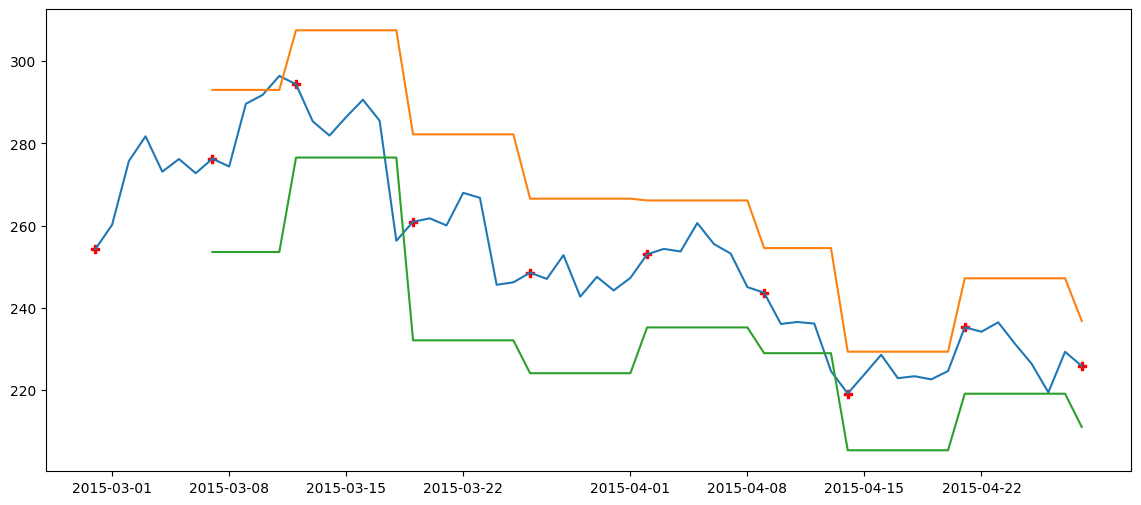

In [222]:
plot_df = labeled_df[0:60]
# Create a new DataFrame where 'window_start' is True
window_starts = plot_df[plot_df['window_start']]

plt.subplots(figsize=(14, 6))

# Plot the 'close', 'upper_barrier', and 'lower_barrier' columns
plt.plot(plot_df.index, plot_df[['close', 'upper_barrier', 'lower_barrier']], ms=1)

# Add markers at the start of each window
plt.scatter(window_starts.index, window_starts['close'], color='red', marker="P")

plt.show()

In [223]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})

    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]

    return bands

In [224]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.

    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='blue')

    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)

        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])

        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 2 else "red" if label["label"] == 0 else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()

    # Show the plot
    plt.show()

[neptune] [error  ] Error occurred during asynchronous operation processing: Cannot upload file /content/drive/MyDrive/LSTM_Impact_Compare.ipynb: Path not found or is a not a file.


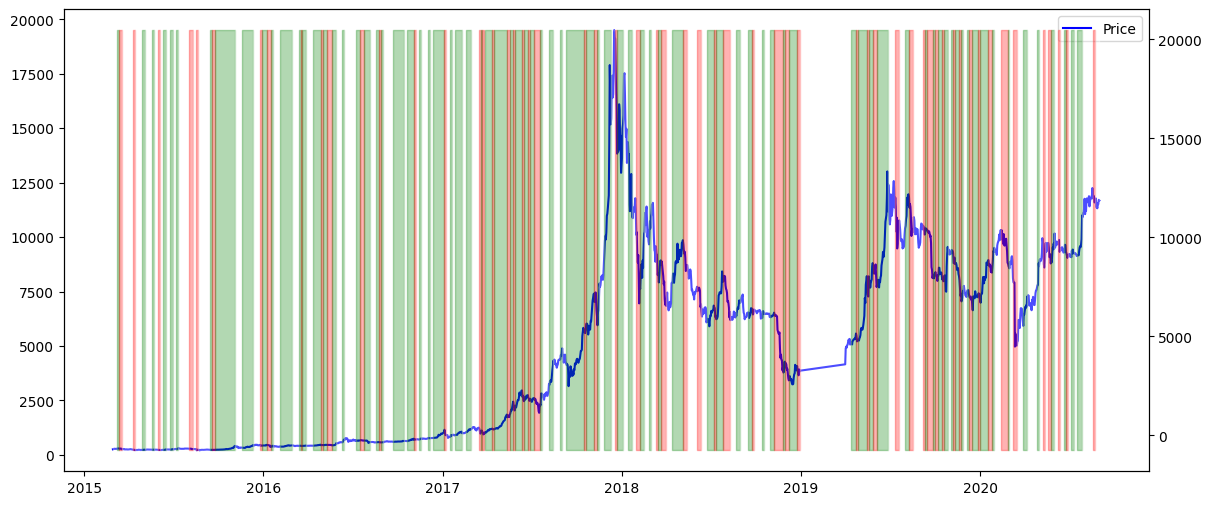

In [225]:
prices = labeled_df
bands = band_generator(prices.label)
plot_labels(prices.close, bands)

In [226]:
price_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio
timestamp,,,,,,,
2015-02-08,227.692993,229.438004,221.076996,223.412003,17145200,0.348485,1
2015-02-09,223.389008,223.977005,217.018997,220.110001,27791300,0.425926,1
2015-02-10,220.281998,221.807007,215.332001,219.839005,21115100,0.719298,1
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1
...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,1
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,1


In [227]:
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,
2015-02-28,253.520004,254.692001,249.479004,254.263000,13949300,0.812500,1,NaN,NaN,1,True,NaN,NaN
2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,1.466667,2,NaN,NaN,1,False,NaN,NaN
2015-03-02,260.356995,276.300995,258.312988,275.670013,40465700,0.509804,2,0.084192,NaN,1,False,NaN,NaN
2015-03-03,275.045990,285.795990,268.161011,281.701996,50461300,1.090909,2,0.082628,0.001106,1,False,NaN,NaN
2015-03-04,281.989990,284.225006,268.126007,273.092010,41383000,1.181818,1,-0.009352,0.055361,1,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425
2020-08-29,11541.054688,11585.640625,11466.292969,11506.865234,17485597759,2.860465,2,0.016203,0.017948,1,True,11857.962363,11197.073650


### Calculate Engineered Features

In [228]:
# Calculate average duration of trends
def calculate_average_duration(df):
    current_label = df['label'].iloc[0]
    duration_sum = 0
    trend_count = 0
    trend_start = df.index[0]
    for i in range(1, len(df)):
        if df['label'].iloc[i] != current_label:
            duration_sum += (df.index[i] - trend_start).days
            trend_count += 1
            trend_start = df.index[i]
            current_label = df['label'].iloc[i]
    average_duration = duration_sum / trend_count if trend_count > 0 else 0
    return average_duration

In [229]:
average_duration = calculate_average_duration(prices)
average_duration

10.01

In [230]:
average_duration = int(average_duration)
average_duration

10

In [231]:
def run_over_trend(df, avg_duration):
    df['run_over_trend'] = 0.0
    window_size = pd.Timedelta(days=avg_duration)

    # Iterate through the dataset in windows of `avg_duration`
    start_date = df.index[0]
    while start_date <= df.index[-1]:
        end_date = start_date + window_size

        # Extract the current window
        window = df[start_date:end_date]

        # Check if the window is empty
        if window.empty:
            # Move to the next window
            start_date = end_date
            continue

        trend_length = (window.index[-1] - window.index[0]).days

        if trend_length == 0:
          # Move to the next window
          start_date = end_date
          continue

        for i, date in enumerate(window.index):
            run_position = (date - window.index[0]).days + 1
            df.loc[date, 'run_over_trend'] = run_position / trend_length

        # Move to the next window
        start_date = end_date

    return df

In [232]:
def rise_over_trend(df, avg_duration):
    # Calculate average percentage change across all trend windows
    trend_changes = []
    window_size = pd.Timedelta(days=avg_duration)

    start_date = df.index[0]
    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if len(window) < 2:
            start_date = end_date
            continue

        start_price = window['close'].iloc[0]
        end_price = window['close'].iloc[-1]
        percentage_change = ((end_price - start_price) / start_price) * 100
        trend_changes.append(percentage_change)

        start_date = end_date

    average_change = sum(trend_changes) / len(trend_changes) if trend_changes else 0

    # Calculate rise_over_trend for each data point
    df['rise_over_trend'] = 0.0
    start_date = df.index[0]

    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if len(window) < 2:
            start_date = end_date
            continue

        start_price = window['close'].iloc[0]
        for date in window.index:
            current_price = window.loc[date, 'close']
            percentage_change = ((current_price - start_price) / start_price) * 100
            df.loc[date, 'rise_over_trend'] = percentage_change / average_change if average_change != 0 else 0

        start_date = end_date

    return df


In [233]:
def previous_window_trend(df, avg_duration):
    df['previous_window_trend'] = 0
    window_size = pd.Timedelta(days=avg_duration)
    previous_label = None

    start_date = df.index[0]

    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if previous_label is not None:
            df.loc[start_date:end_date, 'previous_window_trend'] = previous_label

        if not window.empty:
            previous_label = window['label'].iloc[-1]

        start_date = end_date

    return df


In [234]:
prices = run_over_trend(prices, average_duration)
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend
timestamp,,,,,,,,,,,,,,
2015-02-28,253.520004,254.692001,249.479004,254.263000,13949300,0.812500,1,NaN,NaN,1,True,NaN,NaN,0.1
2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,1.466667,2,NaN,NaN,1,False,NaN,NaN,0.2
2015-03-02,260.356995,276.300995,258.312988,275.670013,40465700,0.509804,2,0.084192,NaN,1,False,NaN,NaN,0.3
2015-03-03,275.045990,285.795990,268.161011,281.701996,50461300,1.090909,2,0.082628,0.001106,1,False,NaN,NaN,0.4
2015-03-04,281.989990,284.225006,268.126007,273.092010,41383000,1.181818,1,-0.009352,0.055361,1,False,NaN,NaN,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9
2020-08-29,11541.054688,11585.640625,11466.292969,11506.865234,17485597759,2.860465,2,0.016203,0.017948,1,True,11857.962363,11197.073650,1.0


In [235]:
prices = rise_over_trend(prices, average_duration)
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend
timestamp,,,,,,,,,,,,,,,
2015-02-28,253.520004,254.692001,249.479004,254.263000,13949300,0.812500,1,NaN,NaN,1,True,NaN,NaN,0.1,0.000000
2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,1.466667,2,NaN,NaN,1,False,NaN,NaN,0.2,0.869494
2015-03-02,260.356995,276.300995,258.312988,275.670013,40465700,0.509804,2,0.084192,NaN,1,False,NaN,NaN,0.3,3.134077
2015-03-03,275.045990,285.795990,268.161011,281.701996,50461300,1.090909,2,0.082628,0.001106,1,False,NaN,NaN,0.4,4.017184
2015-03-04,281.989990,284.225006,268.126007,273.092010,41383000,1.181818,1,-0.009352,0.055361,1,False,NaN,NaN,0.5,2.756646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8,-1.739213
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9,-1.052577
2020-08-29,11541.054688,11585.640625,11466.292969,11506.865234,17485597759,2.860465,2,0.016203,0.017948,1,True,11857.962363,11197.073650,1.0,-1.164251


In [236]:
prices = previous_window_trend(prices, average_duration)
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend
timestamp,,,,,,,,,,,,,,,,
2015-02-28,253.520004,254.692001,249.479004,254.263000,13949300,0.812500,1,NaN,NaN,1,True,NaN,NaN,0.1,0.000000,0
2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,1.466667,2,NaN,NaN,1,False,NaN,NaN,0.2,0.869494,0
2015-03-02,260.356995,276.300995,258.312988,275.670013,40465700,0.509804,2,0.084192,NaN,1,False,NaN,NaN,0.3,3.134077,0
2015-03-03,275.045990,285.795990,268.161011,281.701996,50461300,1.090909,2,0.082628,0.001106,1,False,NaN,NaN,0.4,4.017184,0
2015-03-04,281.989990,284.225006,268.126007,273.092010,41383000,1.181818,1,-0.009352,0.055361,1,False,NaN,NaN,0.5,2.756646,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8,-1.739213,0
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9,-1.052577,0
2020-08-29,11541.054688,11585.640625,11466.292969,11506.865234,17485597759,2.860465,2,0.016203,0.017948,1,True,11857.962363,11197.073650,1.0,-1.164251,0


## LSTM Model for Label Prediction

In [237]:
# Calculate ROC (Rate of Change)
prices['ROC'] = prices['close'].pct_change()

In [238]:
# Calculate RSI
rsi_period = average_duration  # You can choose an appropriate period
rsi_indicator = RSIIndicator(close=prices['close'], window=rsi_period)
prices['RSI'] = rsi_indicator.rsi()

In [239]:
# Calculate Momentum
momentum_period = average_duration  # You can choose an appropriate period
prices['Momentum'] = prices['close'].diff(periods=momentum_period)

In [240]:
# Shift labels to create y_true
prices['y_true'] = prices['label'].shift(-1)

# Drop the last row as it will have NaN for y_true
prices = prices[:-1]

# Convert y_true values to integers
prices['y_true'] = prices['y_true'].astype(int)

<ipython-input-240-bb78914f85c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['y_true'] = prices['y_true'].astype(int)


In [241]:
prices = prices.dropna()
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend,ROC,RSI,Momentum,y_true
timestamp,,,,,,,,,,,,,,,,,,,,
2015-03-10,289.862000,300.044006,289.743011,291.760010,67770800,1.288889,1,0.063444,0.037745,2,False,292.984424,253.564892,0.1,0.000000,2,0.007434,79.297933,37.497009,2
2015-03-11,291.524994,297.390991,290.507996,296.378998,33963900,0.847826,2,0.023383,0.034147,2,False,292.984424,253.564892,0.2,0.589329,2,0.015831,81.625571,36.177002,0
2015-03-12,296.127014,297.088013,292.412994,294.354004,32585200,1.179487,0,0.008891,0.031858,0,True,307.482660,276.536542,0.3,0.330963,2,-0.006832,77.387143,18.683990,0
2015-03-13,294.118011,294.497986,285.337006,285.337006,31421500,1.200000,0,-0.037256,0.037647,0,False,307.482660,276.536542,0.4,-0.819500,2,-0.030633,61.569552,3.635010,0
2015-03-14,284.441986,286.342010,280.976013,281.885010,22612300,0.693878,0,-0.042361,0.040728,0,False,307.482660,276.536542,0.5,-1.259935,2,-0.012098,56.644665,8.792999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,11366.894531,11530.052734,11296.993164,11488.363281,22466660958,2.723404,2,-0.024309,0.019999,1,False,12135.753269,11281.300425,0.7,-1.222233,0,0.010754,47.092898,-404.440430,1
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8,-1.739213,0,-0.014359,42.864143,-931.004883,1
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9,-1.052577,0,0.019350,49.549621,-448.733398,1


In [242]:
# Crop the last 300 rows from the prices dataframe
out_of_sample_df = prices.tail(300)
out_of_sample_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend,ROC,RSI,Momentum,y_true
timestamp,,,,,,,,,,,,,,,,,,,,
2019-10-29,9248.440430,9516.180664,9232.648438,9427.687500,28426779937,1.402985,1,-0.012985,0.097147,1,False,11320.543203,8569.032422,0.5,3.296643,2,0.018532,66.638696,1439.126953,1
2019-10-30,9422.462891,9426.874023,9085.370117,9205.726562,27706531577,1.634921,1,-0.005447,0.082655,1,False,11320.543203,8569.032422,0.6,2.342617,2,-0.023544,61.185588,983.648438,1
2019-10-31,9202.458008,9383.161133,9028.717773,9199.584961,26583653947,1.203947,1,-0.024195,0.072101,1,False,11320.543203,8569.032422,0.7,2.316219,2,-0.000667,61.032042,955.864258,1
2019-11-01,9193.992188,9275.657227,9132.047852,9261.104492,24324691031,3.273381,1,0.006016,0.058879,1,False,11320.543203,8569.032422,0.8,2.580640,2,0.006687,62.090861,1182.901367,1
2019-11-02,9259.783203,9377.486328,9249.587891,9324.717773,21242676385,1.540323,1,0.013602,0.048190,1,False,11320.543203,8569.032422,0.9,2.854061,2,0.006869,63.238485,1810.045898,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,11366.894531,11530.052734,11296.993164,11488.363281,22466660958,2.723404,2,-0.024309,0.019999,1,False,12135.753269,11281.300425,0.7,-1.222233,0,0.010754,47.092898,-404.440430,1
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8,-1.739213,0,-0.014359,42.864143,-931.004883,1
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9,-1.052577,0,0.019350,49.549621,-448.733398,1


In [243]:
# Remove the last 300 rows from the original prices dataframe for training purposes
prices = prices.iloc[:-300]
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend,ROC,RSI,Momentum,y_true
timestamp,,,,,,,,,,,,,,,,,,,,
2015-03-10,289.862000,300.044006,289.743011,291.760010,67770800,1.288889,1,0.063444,0.037745,2,False,292.984424,253.564892,0.1,0.000000,2,0.007434,79.297933,37.497009,2
2015-03-11,291.524994,297.390991,290.507996,296.378998,33963900,0.847826,2,0.023383,0.034147,2,False,292.984424,253.564892,0.2,0.589329,2,0.015831,81.625571,36.177002,0
2015-03-12,296.127014,297.088013,292.412994,294.354004,32585200,1.179487,0,0.008891,0.031858,0,True,307.482660,276.536542,0.3,0.330963,2,-0.006832,77.387143,18.683990,0
2015-03-13,294.118011,294.497986,285.337006,285.337006,31421500,1.200000,0,-0.037256,0.037647,0,False,307.482660,276.536542,0.4,-0.819500,2,-0.030633,61.569552,3.635010,0
2015-03-14,284.441986,286.342010,280.976013,281.885010,22612300,0.693878,0,-0.042361,0.040728,0,False,307.482660,276.536542,0.5,-1.259935,2,-0.012098,56.644665,8.792999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-24,7509.728027,7532.867676,7446.988770,7493.488770,16268708849,1.040268,2,-0.072382,0.048672,2,False,6318.438614,8179.245909,1.0,-3.229577,0,-0.002819,26.115063,-881.197754,2
2019-10-25,7490.703125,8691.540039,7479.984375,8660.700195,28705065488,1.398374,2,0.152505,0.110409,2,False,6318.438614,8179.245909,0.1,0.000000,2,0.155763,60.298281,455.331055,2
2019-10-26,8667.577148,10021.744141,8662.622070,9244.972656,44496255609,1.305970,2,0.233734,0.143371,2,False,6318.438614,8179.245909,0.2,2.511303,2,0.067462,68.423639,1197.445801,1


In [244]:
# Feature
features = [
            'sentiment_ratio',
            'ROC',
            'RSI',
            'Momentum',
            'impact_ratio',
            'rise_over_trend',
            'previous_window_trend',
            ]

In [245]:
# Labels
labels = prices['y_true']

In [246]:
# Define the window length
window_length = average_duration

# Create a function to generate overlapping windows
def create_windows_with_timestamps(df, window_length):
    windows = []
    labels = []
    timestamps = []

    for start in range(len(df) - window_length + 1):
        window = df.iloc[start:start + window_length]
        if window.isnull().values.any():  # Skip windows with missing values
            continue
        windows.append(window[features].values)
        labels.append(window['y_true'].values)
        timestamps.append(window.index)  # Save timestamps for each window

    return np.array(windows), np.array(labels), np.array(timestamps)


In [247]:
# Augment the data by creating overlapping windows
X_augmented, y_augmented, timestamps_augmented = create_windows_with_timestamps(prices, window_length)

In [248]:
len(X_augmented), X_augmented[0], len(X_augmented[0])

(1489,
 array([[ 1.28888889e+00,  7.43426498e-03,  7.92979331e+01,
          3.74970093e+01,  1.00000000e+00,  0.00000000e+00,
          2.00000000e+00],
        [ 8.47826087e-01,  1.58314638e-02,  8.16255705e+01,
          3.61770020e+01,  2.00000000e+00,  5.89328956e-01,
          2.00000000e+00],
        [ 1.17948718e+00, -6.83244734e-03,  7.73871426e+01,
          1.86839905e+01,  0.00000000e+00,  3.30963373e-01,
          2.00000000e+00],
        [ 1.20000000e+00, -3.06331770e-02,  6.15695521e+01,
          3.63500977e+00,  0.00000000e+00, -8.19500354e-01,
          2.00000000e+00],
        [ 6.93877551e-01, -1.20979606e-02,  5.66446648e+01,
          8.79299927e+00,  0.00000000e+00, -1.25993473e+00,
          2.00000000e+00],
        [ 8.94736842e-01,  1.59923212e-02,  6.11533934e+01,
          1.02149963e+01,  0.00000000e+00, -6.84767111e-01,
          2.00000000e+00],
        [ 4.08163265e-01,  1.46650987e-02,  6.49289558e+01,
          1.78699951e+01,  0.00000000e+00, -1.48898

In [249]:
# Shuffle the windows while keeping days in each window together
indices = np.arange(X_augmented.shape[0])
np.random.shuffle(indices)
X_augmented = X_augmented[indices]
y_augmented = y_augmented[indices]
timestamps_augmented = timestamps_augmented[indices]

# Convert the augmented data back into DataFrames for inspection
augmented_data_frames = []
for i in range(len(X_augmented)):
    window_df = pd.DataFrame(X_augmented[i], columns=features, index=timestamps_augmented[i])
    window_df['y_true'] = y_augmented[i]
    augmented_data_frames.append(window_df)

# Combine all augmented windows into a single DataFrame
augmented_df = pd.concat(augmented_data_frames)

In [250]:
augmented_df

,sentiment_ratio,ROC,RSI,Momentum,impact_ratio,rise_over_trend,previous_window_trend,y_true
2019-08-18,1.547826,0.011148,42.411689,-1620.596680,0.0,-0.102365,1.0,1
2019-08-19,1.615385,0.055118,52.901739,-946.882812,0.0,1.943780,1.0,1
2019-08-20,1.693694,-0.014000,50.179949,-590.791992,0.0,1.395427,1.0,1
2019-08-21,3.154639,-0.058085,40.668912,-1385.529297,0.0,-0.847852,1.0,1
2019-08-22,1.666667,-0.000690,40.573320,-1251.560547,0.0,-0.872948,1.0,1
...,...,...,...,...,...,...,...,...
2018-04-17,2.520000,-0.019430,55.536958,991.000000,2.0,0.028899,2.0,2
2018-04-18,1.421875,0.033071,60.143305,1139.899902,2.0,1.260929,2.0,2
2018-04-19,3.410256,0.016034,62.315949,1523.579590,2.0,1.878002,2.0,2
2018-04-20,3.800000,0.066494,69.977939,2011.070312,2.0,4.478123,2.0,2


In [251]:
augmented_df['y_true'].value_counts()

,count
y_true,
2,6900
1,5075
0,2915


### Normal Training/Validation

In [252]:
# Labels
labels = augmented_df['y_true']

In [253]:
majority_file_path = '/content/drive/MyDrive/impact_majority.csv'

impact_majority = pd.read_csv(majority_file_path)
impact_majority = impact_majority.rename(columns={'date': 'timestamp'})
impact_majority = impact_majority.set_index('timestamp')
impact_majority

,impact_label
timestamp,
2015-02-08,1
2015-02-09,1
2015-02-10,1
2015-02-11,1
2015-02-12,1
...,...
2021-02-11,1
2021-02-12,1
2021-02-13,1


In [254]:
impact_majority.impact_label.value_counts()

,count
impact_label,
1,1092
2,545
0,467


In [255]:
mean_file_path = '/content/drive/MyDrive/impact_mean.csv'

impact_mean = pd.read_csv(mean_file_path)
impact_mean = impact_mean.rename(columns={'date': 'timestamp'})
impact_mean = impact_mean.set_index('timestamp')
impact_mean

,signal
timestamp,
2015-02-08,0
2015-02-09,0
2015-02-10,0
2015-02-11,0
2015-02-12,0
...,...
2021-02-11,0
2021-02-12,0
2021-02-13,0


In [256]:
impact_mean.signal.value_counts()

,count
signal,
0,929
1,698
-1,477


In [257]:
# Map the signal values from [-1, 0, 1] to [0, 1, 2]
impact_mean['mean_label'] = impact_mean['signal'].map({-1: 0, 0: 1, 1: 2})
impact_mean

,signal,mean_label
timestamp,,
2015-02-08,0,1
2015-02-09,0,1
2015-02-10,0,1
2015-02-11,0,1
2015-02-12,0,1
...,...,...
2021-02-11,0,1
2021-02-12,0,1
2021-02-13,0,1


In [258]:
impact_mean.mean_label.value_counts()

,count
mean_label,
1,929
2,698
0,477


### KFold Training/Validation

In [259]:
augmented_df

,sentiment_ratio,ROC,RSI,Momentum,impact_ratio,rise_over_trend,previous_window_trend,y_true
2019-08-18,1.547826,0.011148,42.411689,-1620.596680,0.0,-0.102365,1.0,1
2019-08-19,1.615385,0.055118,52.901739,-946.882812,0.0,1.943780,1.0,1
2019-08-20,1.693694,-0.014000,50.179949,-590.791992,0.0,1.395427,1.0,1
2019-08-21,3.154639,-0.058085,40.668912,-1385.529297,0.0,-0.847852,1.0,1
2019-08-22,1.666667,-0.000690,40.573320,-1251.560547,0.0,-0.872948,1.0,1
...,...,...,...,...,...,...,...,...
2018-04-17,2.520000,-0.019430,55.536958,991.000000,2.0,0.028899,2.0,2
2018-04-18,1.421875,0.033071,60.143305,1139.899902,2.0,1.260929,2.0,2
2018-04-19,3.410256,0.016034,62.315949,1523.579590,2.0,1.878002,2.0,2
2018-04-20,3.800000,0.066494,69.977939,2011.070312,2.0,4.478123,2.0,2


In [260]:
# Define number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)

# Initialize lists to store metrics for each fold
accuracy_list = []
f1_list = []
recall_list = []
precision_list = []

# Initialize lists to store impact_majority metrics for each fold
majority_accuracy_list = []
majority_f1_list = []
majority_recall_list = []
majority_precision_list = []

# Initialize lists to store mean_majority metrics for each fold
mean_accuracy_list = []
mean_f1_list = []
mean_recall_list = []
mean_precision_list = []

# Training logs histories
all_history = []

In [261]:
def lstm_model(X_train):
  # LSTM Model with increased capacity
  model = Sequential()

  # First LSTM layer with increased units and return_sequences=True for stacking
  model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(0.4))

  # Second LSTM layer with return_sequences=False for final output
  model.add(LSTM(64, return_sequences=False))
  model.add(Dropout(0.3))

  # Dense layer for additional capacity
  model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.005)))
  model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))

  # Output layer
  model.add(Dense(3, activation='softmax'))

  # Compile the model with a slightly reduced learning rate
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0005),
                metrics=['accuracy'])

  return model

In [262]:
# Add a 'day' column that captures the day part from the index
augmented_df['day'] = augmented_df.index.day

# Groups will be based on the 'day' column
groups = augmented_df['day']

# Initialize GroupKFold with specified number of folds
group_kfold = GroupKFold(n_splits=5)  # You can modify the n_splits as required

In [263]:
# K-Fold Cross-Validation
fold_num = 0
# Perform GroupKFold splitting
for fold, (train_index, val_index) in tqdm(enumerate(group_kfold.split(augmented_df, augmented_df['y_true'], groups)), desc='Fold Progress...'):
    fold_num += 1

    # Split the data into training and val sets
    X_train, X_val = augmented_df.iloc[train_index][features], augmented_df.iloc[val_index][features]
    y_train, y_val = augmented_df.iloc[train_index]['y_true'].values, augmented_df.iloc[val_index]['y_true'].values
    train_timestamps, val_timestamps = augmented_df.index[train_index], augmented_df.index[val_index]

    # Verify that there are no overlapping days between the training and validation sets
    train_days = set(augmented_df.iloc[train_index]['day'])
    val_days = set(augmented_df.iloc[val_index]['day'])
    assert train_days.isdisjoint(val_days), f"Overlap detected in fold {fold}"

    train_days = set(train_timestamps)
    val_days = set(val_timestamps)
    assert train_days.isdisjoint(val_days), f"Overlap detected in fold {fold}, Index"

    # Preprocessing inside each fold
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[features])
    X_val = scaler.transform(X_val[features])

    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Convert labels to categorical for multi-class classification
    y_train = to_categorical(y_train, num_classes=3)
    y_val_categorical = to_categorical(y_val, num_classes=3)

    neptune_callback = NeptuneCallback(
        run=run,
        base_namespace='Train LSTM using KFold and compare results.',
        log_on_batch=True,
        log_model_diagram=False,  # Requires pydot to be installed
    )

    model = lstm_model(X_train)

    # Train the LSTM model (same as before)
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val_categorical),
                        epochs=30,
                        batch_size=128,
                        verbose=1,
                        callbacks=[neptune_callback]
                        )
    all_history.append(history)

    # Evaluation
    loss, accuracy = model.evaluate(X_val, y_val_categorical, verbose=1)
    print(f'Test Accuracy after Fold {fold_num}: {accuracy:.4f}')

    # Log final evaluation metrics to Neptune
    run[f"LSTM_Eval/Fold{fold_num}/test_loss"] = loss
    run[f"LSTM_Eval/Fold{fold_num}/test_accuracy"] = accuracy

    # Evaluate LSTM on the test fold
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Pair predictions with timestamps for inspection or further use
    predictions_with_timestamps = pd.DataFrame({
        'timestamp': val_timestamps,  # Ensure it's a 1D array
        'y_true': y_val,
        'y_pred': y_pred_classes
    })

    # Remove duplicate timestamps, keeping only the first occurrence
    predictions_unique = predictions_with_timestamps.drop_duplicates(subset=['timestamp'], keep='first')
    predictions_unique = predictions_unique.set_index('timestamp')
    predictions_unique.sort_index()

    # Convert indices to datetime if they are not already
    predictions_unique.index = pd.to_datetime(predictions_unique.index)
    impact_majority.index = pd.to_datetime(impact_majority.index)
    impact_mean.index = pd.to_datetime(impact_mean.index)

    # Find common timestamps between predictions_unique and impact_majority
    common_timestamps = predictions_unique.index.intersection(impact_majority.index)

    # Find common timestamps between predictions_unique and impact_mean
    common_timestamps = impact_mean.index.intersection(common_timestamps)

    # Extract rows with common timestamps from both dataframes
    predictions_common = predictions_unique.loc[common_timestamps]
    majority_common = impact_majority.loc[common_timestamps]
    mean_common = impact_mean.loc[common_timestamps]

    # Create a new DataFrame 'all_results' with common timestamps
    results = pd.DataFrame(index=common_timestamps)

    # Add 'impact_label', 'y_true', and 'y_pred' to 'all_results'
    results['impact_label'] = majority_common['impact_label']
    results['mean_label'] = mean_common['mean_label']
    results['lstm_label'] = predictions_common['y_pred']
    results['y_true'] = predictions_common['y_true']

    # Calculate evaluation metrics
    lstm_accuracy = accuracy_score(results['y_true'], results['lstm_label'])
    accuracy_list.append(lstm_accuracy)
    lstm_f1 = f1_score(results['y_true'], results['lstm_label'], average='weighted')
    f1_list.append(lstm_f1)
    lstm_recall = recall_score(results['y_true'], results['lstm_label'], average='weighted')
    recall_list.append(lstm_recall)
    lstm_precision = precision_score(results['y_true'], results['lstm_label'], average='weighted')
    precision_list.append(lstm_precision)

    # Calculate evaluation metrics
    majority_accuracy = accuracy_score(results['y_true'], results['impact_label'])
    majority_accuracy_list.append(majority_accuracy)
    majority_f1 = f1_score(results['y_true'], results['impact_label'], average='weighted')
    majority_f1_list.append(majority_f1)
    majority_recall = recall_score(results['y_true'], results['impact_label'], average='weighted')
    majority_recall_list.append(majority_recall)
    majority_precision = precision_score(results['y_true'], results['impact_label'], average='weighted')
    majority_precision_list.append(majority_precision)

    # Calculate evaluation metrics
    mean_accuracy = accuracy_score(results['y_true'], results['mean_label'])
    mean_accuracy_list.append(mean_accuracy)
    mean_f1 = f1_score(results['y_true'], results['mean_label'], average='weighted')
    mean_f1_list.append(mean_f1)
    mean_recall = recall_score(results['y_true'], results['mean_label'], average='weighted')
    mean_recall_list.append(mean_recall)
    mean_precision = precision_score(results['y_true'], results['mean_label'], average='weighted')
    mean_precision_list.append(mean_precision)

    # Log additional metrics to Neptune
    run[f"LSTM_Eval/Fold{fold_num}/accuracy"] = lstm_accuracy
    run[f"LSTM_Eval/Fold{fold_num}/f1_score"] = lstm_f1
    run[f"LSTM_Eval/Fold{fold_num}/recall"] = lstm_recall
    run[f"LSTM_Eval/Fold{fold_num}/precision"] = lstm_precision

    run[f"Majority_Eval/Fold{fold_num}/accuracy"] = majority_accuracy
    run[f"Majority_Eval/Fold{fold_num}/f1_score"] = majority_f1
    run[f"Majority_Eval/Fold{fold_num}/recall"] = majority_recall
    run[f"Majority_Eval/Fold{fold_num}/precision"] = majority_precision

    run[f"Mean_Eval/Fold{fold_num}/accuracy"] = mean_accuracy
    run[f"Mean_Eval/Fold{fold_num}/f1_score"] = mean_f1
    run[f"Mean_Eval/Fold{fold_num}/recall"] = mean_recall
    run[f"Mean_Eval/Fold{fold_num}/precision"] = mean_precision

Fold Progress...: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.4464 - loss: 1.5525 - val_accuracy: 0.4942 - val_loss: 1.2875
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4970 - loss: 1.2434 - val_accuracy: 0.5828 - val_loss: 1.1032
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5542 - loss: 1.0935 - val_accuracy: 0.5965 - val_loss: 1.0140
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5769 - loss: 1.0076 - val_accuracy: 0.6203 - val_loss: 0.9491
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6158 - loss: 0.9387 - val_accuracy: 0.6387 - val_loss: 0.9179
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6394 - loss: 0.8885 - val_accuracy: 0.6353 - val_loss: 0.8873
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6389 - loss: 0.8861 - val_accuracy: 0.6489 - val_loss: 0.8783
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6525 - loss: 0.8664 - val_accuracy: 0.6421 - 

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6271 - loss: 0.8324
Test Accuracy after Fold 1: 0.6149
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4526 - loss: 1.5384 - val_accuracy: 0.5111 - val_loss: 1.2373
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5129 - loss: 1.2262 - val_accuracy: 0.5983 - val_loss: 1.0636
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5600 - loss: 1.0849 - val_accuracy: 0.5983 - val_loss: 0.9778
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5958 - loss: 0.9952 - val_accuracy: 0.6085 - val_loss: 0.9313
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6089 - loss: 0.9459 - val_accuracy: 0.6318 - val_loss: 0.8886
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6185 - loss: 0.9193 - val_accuracy: 0.6677 - val_loss: 0.8630
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6364 - loss: 0.8836 - val_accuracy: 0.6779 - val_loss: 0.8545
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6369 - loss: 0.8727 - val_accuracy: 0.6848 - val_loss: 0.

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6569 - loss: 0.8228
Test Accuracy after Fold 2: 0.6711
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4289 - loss: 1.5438 - val_accuracy: 0.4896 - val_loss: 1.3040
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5103 - loss: 1.2315 - val_accuracy: 0.5589 - val_loss: 1.1246
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5618 - loss: 1.0773 - val_accuracy: 0.5683 - val_loss: 1.0337
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6052 - loss: 0.9770 - val_accuracy: 0.6030 - val_loss: 0.9749
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6193 - loss: 0.9203 - val_accuracy: 0.6281 - val_loss: 0.9332
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6330 - loss: 0.8967 - val_accuracy: 0.6250 - val_loss: 0.9101
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6509 - loss: 0.8733 - val_accuracy: 0.6470 - val_loss: 0.8911
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6424 - loss: 0.8712 - val_accuracy: 0.6376 - val_loss: 0.

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6375 - loss: 0.8660
Test Accuracy after Fold 3: 0.6502
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4591 - loss: 1.5266 - val_accuracy: 0.4500 - val_loss: 1.2792
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5150 - loss: 1.2202 - val_accuracy: 0.4671 - val_loss: 1.1275
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5533 - loss: 1.0806 - val_accuracy: 0.4944 - val_loss: 1.0430
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5700 - loss: 1.0009 - val_accuracy: 0.5285 - val_loss: 0.9835
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5919 - loss: 0.9548 - val_accuracy: 0.5766 - val_loss: 0.9394
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6234 - loss: 0.9063 - val_accuracy: 0.6141 - val_loss: 0.9037
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6455 - loss: 0.8720 - val_accuracy: 0.6090 - val_loss: 0.8934
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6620 - loss: 0.8538 - val_accuracy: 0.6056 - v

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6213 - loss: 0.8580
Test Accuracy after Fold 4: 0.6257
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4489 - loss: 1.5347 - val_accuracy: 0.4754 - val_loss: 1.3000
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5126 - loss: 1.2095 - val_accuracy: 0.4959 - val_loss: 1.1385
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5426 - loss: 1.0818 - val_accuracy: 0.5404 - val_loss: 1.0557
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5743 - loss: 1.0001 - val_accuracy: 0.5438 - val_loss: 1.0035
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5900 - loss: 0.9538 - val_accuracy: 0.5814 - val_loss: 0.9647
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5998 - loss: 0.9280 - val_accuracy: 0.5858 - val_loss: 0.9426
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6249 - loss: 0.8875 - val_accuracy: 0.6098 - val_loss: 0.9075
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6441 - loss: 0.8659 - val_accuracy: 0.6166 - val_loss: 0.

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6460 - loss: 0.8097
Test Accuracy after Fold 5: 0.6460
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [264]:
# Average the metrics over all folds
avg_accuracy = np.mean(accuracy_list)
avg_f1 = np.mean(f1_list)
avg_recall = np.mean(recall_list)
avg_precision = np.mean(precision_list)

avg_majority_accuracy = np.mean(majority_accuracy_list)
avg_majority_f1 = np.mean(majority_f1_list)
avg_majority_recall = np.mean(majority_recall_list)
avg_majority_precision = np.mean(majority_precision_list)

avg_mean_accuracy = np.mean(mean_accuracy_list)
avg_mean_f1 = np.mean(mean_f1_list)
avg_mean_recall = np.mean(mean_recall_list)
avg_mean_precision = np.mean(mean_precision_list)

# Output the results
print(f"LSTM Model (5-Fold Avg) - Accuracy: {avg_accuracy:.4f}, F1: {avg_f1:.4f}, Recall: {avg_recall:.4f}, Precision: {avg_precision:.4f}")
print(f"Impact Majority (5-Fold Avg) - Accuracy: {avg_majority_accuracy:.4f}, F1: {avg_majority_f1:.4f}, Recall: {avg_majority_recall:.4f}, Precision: {avg_majority_precision:.4f}")
print(f"Impact Mean (5-Fold Avg) - Accuracy: {avg_mean_accuracy:.4f}, F1: {avg_mean_f1:.4f}, Recall: {avg_mean_recall:.4f}, Precision: {avg_mean_precision:.4f}")

LSTM Model (5-Fold Avg) - Accuracy: 0.6407, F1: 0.6389, Recall: 0.6407, Precision: 0.6431
Impact Majority (5-Fold Avg) - Accuracy: 0.4599, F1: 0.4608, Recall: 0.4599, Precision: 0.5109
Impact Mean (5-Fold Avg) - Accuracy: 0.4805, F1: 0.4860, Recall: 0.4805, Precision: 0.5083


In [265]:
# Log additional metrics to Neptune
run["LSTM_Eval/accuracy"] = avg_accuracy
run["LSTM_Eval/f1_score"] = avg_f1
run["LSTM_Eval/recall"] = avg_recall
run["LSTM_Eval/precision"] = avg_precision

run["Majority_Eval/accuracy"] = avg_majority_accuracy
run["Majority_Eval/f1_score"] = avg_majority_f1
run["Majority_Eval/recall"] = avg_majority_recall
run["Majority_Eval/precision"] = avg_majority_precision

run["Mean_Eval/accuracy"] = avg_mean_accuracy
run["Mean_Eval/f1_score"] = avg_mean_f1
run["Mean_Eval/recall"] = avg_mean_recall
run["Mean_Eval/precision"] = avg_mean_precision

# Stop the Neptune run
run.stop()

In [266]:
print(classification_report(y_val, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.6981    0.4669    0.5595       619
           1     0.6538    0.6667    0.6602      1020
           2     0.6259    0.7160    0.6679      1285

    accuracy                         0.6460      2924
   macro avg     0.6593    0.6165    0.6292      2924
weighted avg     0.6509    0.6460    0.6423      2924



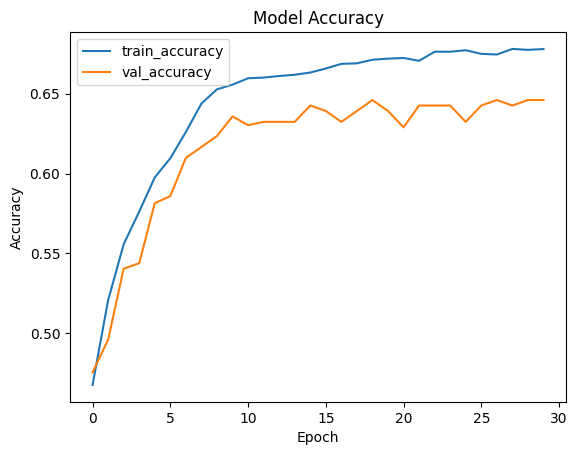

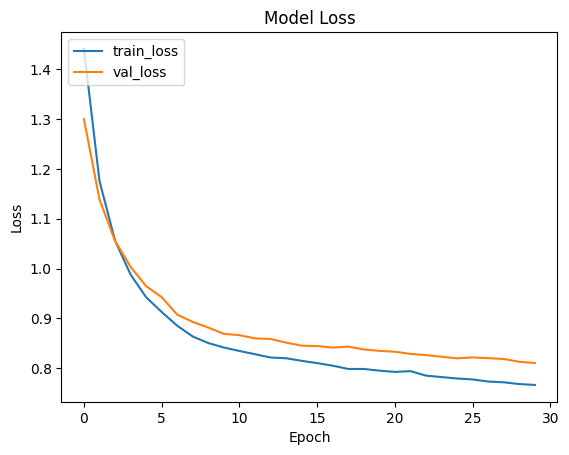

In [267]:
# Optionally, you can plot the training history to check the training process
import matplotlib.pyplot as plt

fold_history = 5
history = all_history[fold_history-1]

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

                       sentiment_ratio       ROC       RSI  Momentum  \
sentiment_ratio               1.000000 -0.040735 -0.139956 -0.009369   
ROC                          -0.040735  1.000000  0.392008  0.265442   
RSI                          -0.139956  0.392008  1.000000  0.533131   
Momentum                     -0.009369  0.265442  0.533131  1.000000   
impact_ratio                  0.004426  0.277555  0.229910  0.076608   
rise_over_trend              -0.003279  0.421373  0.662524  0.585868   
previous_window_trend        -0.097743  0.197673  0.505620  0.267864   
y_true                       -0.112897  0.138621  0.129755 -0.021616   

                       impact_ratio  rise_over_trend  previous_window_trend  \
sentiment_ratio            0.004426        -0.003279              -0.097743   
ROC                        0.277555         0.421373               0.197673   
RSI                        0.229910         0.662524               0.505620   
Momentum                   0.076608

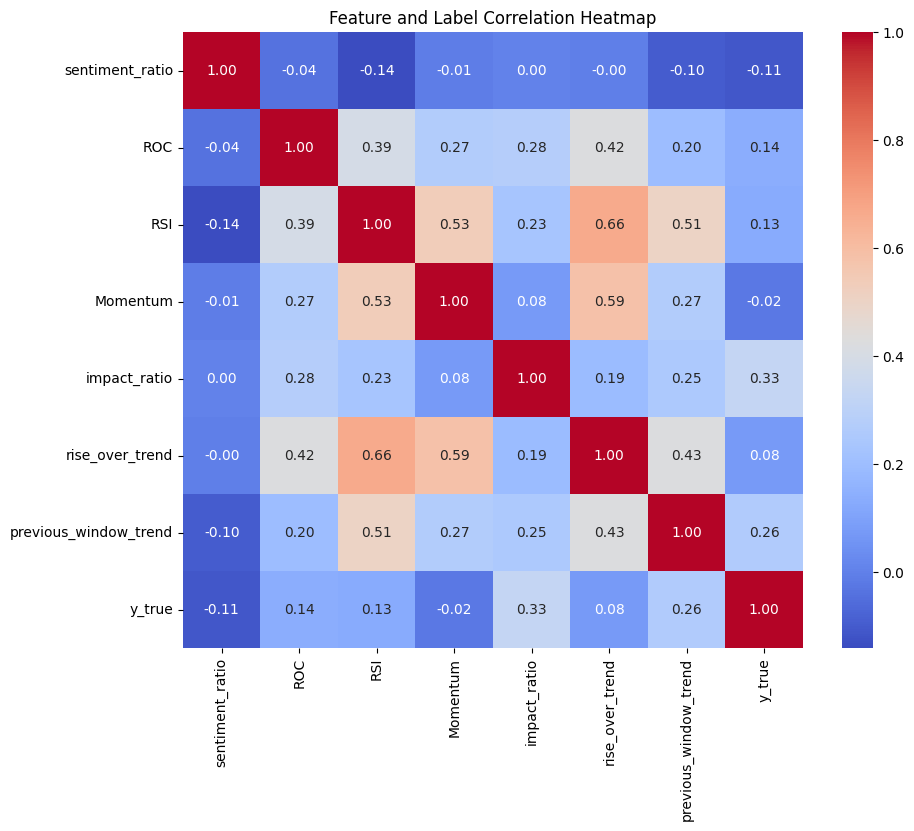

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix including the y_true
correlation_matrix_with_label = prices[features + ['y_true']].corr()

# Display the correlation matrix
print(correlation_matrix_with_label)

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_label, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Feature and Label Correlation Heatmap')
plt.show()

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


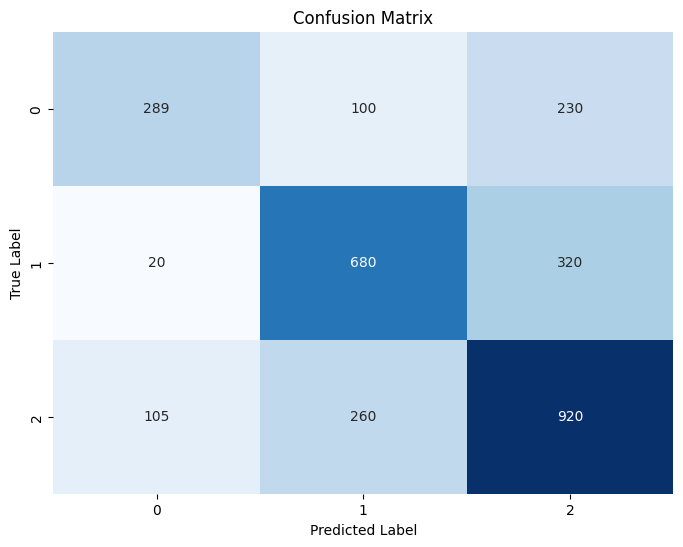

In [269]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_val)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true_classes = y_val
# y_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Out of Sample Test

In [270]:
out_of_sample_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend,ROC,RSI,Momentum,y_true
timestamp,,,,,,,,,,,,,,,,,,,,
2019-10-29,9248.440430,9516.180664,9232.648438,9427.687500,28426779937,1.402985,1,-0.012985,0.097147,1,False,11320.543203,8569.032422,0.5,3.296643,2,0.018532,66.638696,1439.126953,1
2019-10-30,9422.462891,9426.874023,9085.370117,9205.726562,27706531577,1.634921,1,-0.005447,0.082655,1,False,11320.543203,8569.032422,0.6,2.342617,2,-0.023544,61.185588,983.648438,1
2019-10-31,9202.458008,9383.161133,9028.717773,9199.584961,26583653947,1.203947,1,-0.024195,0.072101,1,False,11320.543203,8569.032422,0.7,2.316219,2,-0.000667,61.032042,955.864258,1
2019-11-01,9193.992188,9275.657227,9132.047852,9261.104492,24324691031,3.273381,1,0.006016,0.058879,1,False,11320.543203,8569.032422,0.8,2.580640,2,0.006687,62.090861,1182.901367,1
2019-11-02,9259.783203,9377.486328,9249.587891,9324.717773,21242676385,1.540323,1,0.013602,0.048190,1,False,11320.543203,8569.032422,0.9,2.854061,2,0.006869,63.238485,1810.045898,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,11366.894531,11530.052734,11296.993164,11488.363281,22466660958,2.723404,2,-0.024309,0.019999,1,False,12135.753269,11281.300425,0.7,-1.222233,0,0.010754,47.092898,-404.440430,1
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,3.500000,2,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8,-1.739213,0,-0.014359,42.864143,-931.004883,1
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,1.640625,2,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9,-1.052577,0,0.019350,49.549621,-448.733398,1


In [271]:
# Apply the scaler that was fitted on the training set to the out-of-sample set
# scaler = StandardScaler()
out_of_sample_df[features] = scaler.fit_transform(out_of_sample_df[features])
out_of_sample_df

<ipython-input-271-e9e43f76be54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_df[features] = scaler.fit_transform(out_of_sample_df[features])


,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend,ROC,RSI,Momentum,y_true
timestamp,,,,,,,,,,,,,,,,,,,,
2019-10-29,9248.440430,9516.180664,9232.648438,9427.687500,28426779937,-0.840683,0.004969,-0.012985,0.097147,1,False,11320.543203,8569.032422,0.5,1.193247,1.166019,0.447877,0.869893,1.402700,1
2019-10-30,9422.462891,9426.874023,9085.370117,9205.726562,27706531577,-0.540978,0.004969,-0.005447,0.082655,1,False,11320.543203,8569.032422,0.6,0.790599,1.166019,-0.649190,0.508870,0.918262,1
2019-10-31,9202.458008,9383.161133,9028.717773,9199.584961,26583653947,-1.097878,0.004969,-0.024195,0.072101,1,False,11320.543203,8569.032422,0.7,0.779458,1.166019,-0.052723,0.498705,0.888711,1
2019-11-01,9193.992188,9275.657227,9132.047852,9261.104492,24324691031,1.576228,0.004969,0.006016,0.058879,1,False,11320.543203,8569.032422,0.8,0.891057,1.166019,0.139031,0.568804,1.130184,1
2019-11-02,9259.783203,9377.486328,9249.587891,9324.717773,21242676385,-0.663217,0.004969,0.013602,0.048190,1,False,11320.543203,8569.032422,0.9,1.006455,1.166019,0.143767,0.644782,1.797203,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,11366.894531,11530.052734,11296.993164,11488.363281,22466660958,0.865552,1.495699,-0.024309,0.019999,1,False,12135.753269,11281.300425,0.7,-0.713952,-1.406082,0.245059,-0.424136,-0.558084,1
2020-08-27,11485.608398,11570.786133,11185.941406,11323.397461,23240415076,1.869063,1.495699,-0.003760,0.018207,1,False,12135.753269,11281.300425,0.8,-0.932144,-1.406082,-0.409728,-0.704101,-1.118128,1
2020-08-28,11325.295898,11545.615234,11316.422852,11542.500000,19807127588,-0.533607,1.495699,0.004712,0.017250,1,False,12135.753269,11281.300425,0.9,-0.642348,-1.406082,0.469182,-0.261489,-0.605193,1


In [272]:
# Make predictions on the out_of_sample_df (we assume X_test contains the features of the test set)
X_out_of_sample = out_of_sample_df[features].values  # Assuming features is already defined
X_out_of_sample.shape

(300, 7)

In [273]:
# Make predictions on the out_of_sample_df (we assume X_test contains the features of the test set)
X_out_of_sample = out_of_sample_df[features].values  # Assuming features is already defined
y_true_out_of_sample = out_of_sample_df['y_true'].values  # Extract the true labels from the out_of_sample_df

# Reshape data for LSTM input (if required)
X_out_of_sample = X_out_of_sample.reshape((X_out_of_sample.shape[0], 1, X_out_of_sample.shape[1]))

# Use the trained model to make predictions
y_pred_out_of_sample = model.predict(X_out_of_sample)

# Convert the predicted probabilities into classes (if it's classification)
y_pred_classes_out_of_sample = np.argmax(y_pred_out_of_sample, axis=1)

# Create a DataFrame to hold the results
out_of_sample_results = pd.DataFrame({
    'timestamp': out_of_sample_df.index,  # Add the timestamp
    'y_true': y_true_out_of_sample,       # Add the true labels
    'y_pred': y_pred_classes_out_of_sample  # Add the predicted labels
})
out_of_sample_results = out_of_sample_results.set_index('timestamp')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [274]:
# Calculate evaluation metrics
accuracy = accuracy_score(out_of_sample_results['y_true'], out_of_sample_results['y_pred'])
precision = precision_score(out_of_sample_results['y_true'], out_of_sample_results['y_pred'], average='weighted')
recall = recall_score(out_of_sample_results['y_true'], out_of_sample_results['y_pred'], average='weighted')
f1 = f1_score(out_of_sample_results['y_true'], out_of_sample_results['y_pred'], average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display the results DataFrame (optional)
out_of_sample_results.head()

Accuracy: 0.5100
Precision: 0.5485
Recall: 0.5100
F1 Score: 0.4980


,y_true,y_pred
timestamp,,
2019-10-29,1,2
2019-10-30,1,2
2019-10-31,1,2
2019-11-01,1,0
2019-11-02,2,2


In [275]:
# Convert indices to datetime if they are not already
out_of_sample_df.index = pd.to_datetime(out_of_sample_df.index)
impact_majority.index = pd.to_datetime(impact_majority.index)
impact_mean.index = pd.to_datetime(impact_mean.index)

# Find common timestamps between predictions_unique and impact_majority
common_timestamps = out_of_sample_df.index.intersection(impact_majority.index)

# Extract rows with common timestamps from both dataframes
majority_common = impact_majority.loc[common_timestamps]

# Find common timestamps between predictions_unique and impact_mean
common_timestamps = out_of_sample_df.index.intersection(impact_mean.index)

# Extract rows with common timestamps from both dataframes
mean_common = impact_mean.loc[common_timestamps]

# Create a new DataFrame 'all_results' with common timestamps
results = pd.DataFrame(index=common_timestamps)

# Add 'impact_label', 'y_true', and 'y_pred' to 'all_results'
results['impact_label'] = majority_common['impact_label']
results['mean_label'] = mean_common['mean_label']
results['lstm_label'] = out_of_sample_results['y_pred']
results['y_true'] = out_of_sample_df['y_true']

# Calculate evaluation metrics
lstm_accuracy = accuracy_score(results['y_true'], results['lstm_label'])
lstm_f1 = f1_score(results['y_true'], results['lstm_label'], average='weighted')
lstm_recall = recall_score(results['y_true'], results['lstm_label'], average='weighted')
lstm_precision = precision_score(results['y_true'], results['lstm_label'], average='weighted')

# Calculate evaluation metrics
majority_accuracy = accuracy_score(results['y_true'], results['impact_label'])
majority_f1 = f1_score(results['y_true'], results['impact_label'], average='weighted')
majority_recall = recall_score(results['y_true'], results['impact_label'], average='weighted')
majority_precision = precision_score(results['y_true'], results['impact_label'], average='weighted')

# Calculate evaluation metrics
mean_accuracy = accuracy_score(results['y_true'], results['mean_label'])
mean_f1 = f1_score(results['y_true'], results['mean_label'], average='weighted')
mean_recall = recall_score(results['y_true'], results['mean_label'], average='weighted')
mean_precision = precision_score(results['y_true'], results['mean_label'], average='weighted')

In [276]:
lstm_accuracy, majority_accuracy, mean_accuracy

(0.51, 0.5333333333333333, 0.5366666666666666)

In [279]:
# Log additional metrics to Neptune
run[f"LSTM_Out_of_Sample_Test/accuracy"] = lstm_accuracy
run[f"LSTM_Out_of_Sample_Test/f1_score"] = lstm_f1
run[f"LSTM_Out_of_Sample_Test/recall"] = lstm_recall
run[f"LSTM_Out_of_Sample_Test/precision"] = lstm_precision

run[f"Majority_Out_of_Sample_Test/accuracy"] = majority_accuracy
run[f"Majority_Out_of_Sample_Test/f1_score"] = majority_f1
run[f"Majority_Out_of_Sample_Test/recall"] = majority_recall
run[f"Majority_Out_of_Sample_Test/precision"] = majority_precision

run[f"Mean_Out_of_Sample_Test/accuracy"] = mean_accuracy
run[f"Mean_Out_of_Sample_Test/f1_score"] = mean_f1
run[f"Mean_Out_of_Sample_Test/recall"] = mean_recall
run[f"Mean_Out_of_Sample_Test/precision"] = mean_precision

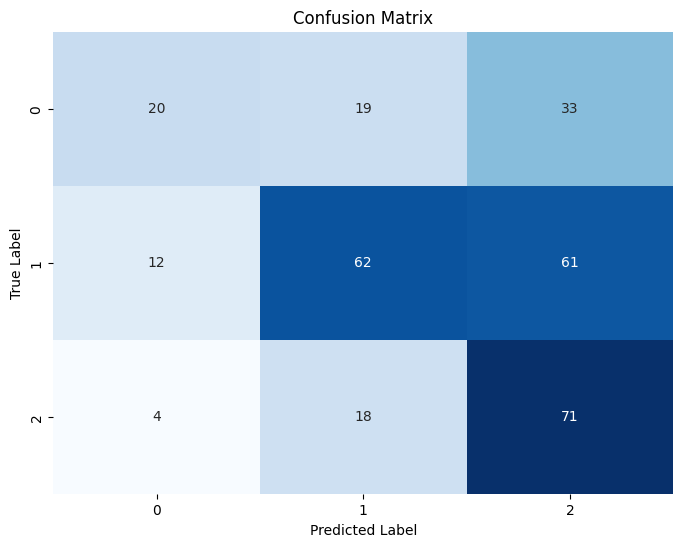

In [281]:
# Generate the confusion matrix
cm = confusion_matrix(out_of_sample_results['y_true'], out_of_sample_results['y_pred'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()